In [124]:
import pandas as pd
import numpy as np
import spacy
import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split

In [368]:
test = pd.read_csv('./data/testing.csv')
train = pd.read_csv('./data/balanced_full.csv')

In [369]:
print(train.groupby('star_rating').count())

             review_body
star_rating             
1                  24996
2                  24998
3                  24995
4                  24997
5                  24996


In [319]:
allowed_labels = ['1','2','3','4','5']
# for index, row in test.iterrows():
#     if (str(row['star_rating']).strip() not in allowed_labels) or (len(str(row['review_body']).strip()) < 3):
#         test.drop(index, inplace=True)

In [326]:
model = spacy.load('./models/reviews_1_balanced_full')

In [304]:
def createAnnotation(rating: str):
        annot = {
            'cats':{
                '5' : False,
                '4' : False,
                '3' : False,
                '2' : False,
                '1' : False,
                }
            }
        annot['cats'][rating] = True
        return annot

In [337]:
TEST_DATA = list()
y_ = []
sample_size = len(test)
for index, row in test.sample(n=sample_size).iterrows():
    if (str(row['star_rating']).strip() not in allowed_labels) or (len(str(row['review_body']).strip()) < 3):
      continue
    annotation = createAnnotation(str(row['star_rating']).strip())
    y_.append(row['star_rating'])
    TEST_DATA.append((str(row['review_body']).strip(), annotation))
y_pred = []
y_pred_class = []
for input_, annotations in TEST_DATA:
    pred = model(input_)
    y_pred.append(list(pred.cats.values()))
    y_pred_class.append(int(max(pred.cats, key=pred.cats.get)))

y_pred = np.array(y_pred)
y_true = pd.DataFrame(y_).squeeze()

In [339]:
classes = model.get_pipe('textcat').labels
classes = [int(i) for i in classes]
classes_combinations = []
class_list = list(classes)
for i in range(len(class_list)):
    for j in range(i+1, len(class_list)):
        classes_combinations.append([class_list[i], class_list[j]])
        classes_combinations.append([class_list[j], class_list[i]])

In [342]:
def calculate_tpr_fpr(y_real, y_pred):
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr



In [343]:

def get_all_roc_coordinates(y_real, y_proba):
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list


In [344]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    if scatter:
        sns.scatterplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")


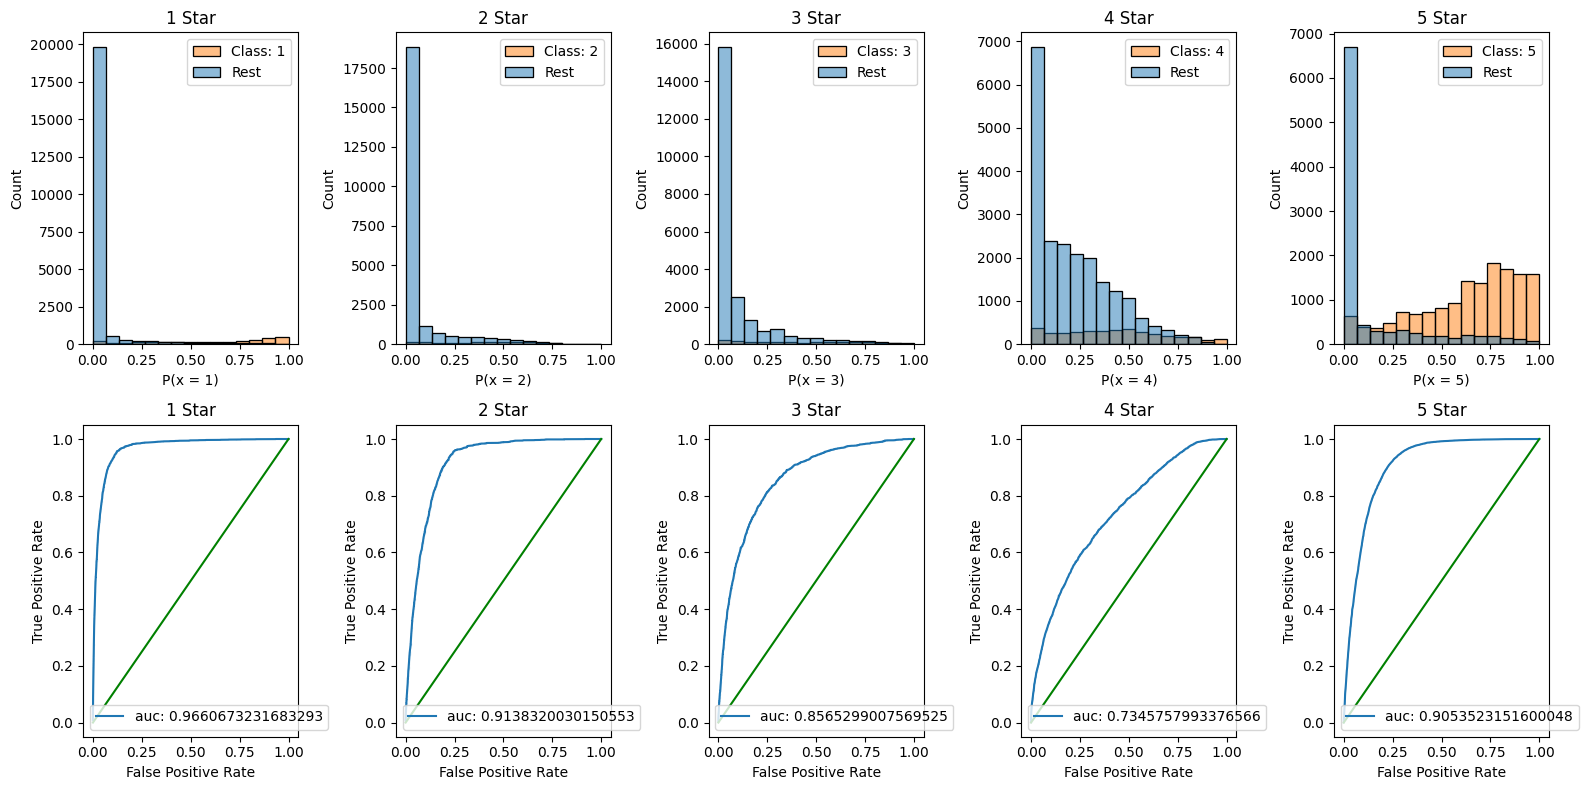

In [384]:
plt.figure(figsize = (16, 8))
bins = [i/15 for i in range(15)] + [1]
roc_auc_ovr = {}
for i in range(len(classes)):
    # Gets the class
    c = classes[i]

    # Prepares an auxiliar dataframe to help with the plots
    df_aux = pd.DataFrame(columns=['class', 'prob'])
    df_aux['class'] = [1 if y == c else 0 for y in y_true]
    df_aux['prob'] = y_pred[:, i]
    df_aux = df_aux.reset_index(drop = True)

    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 5, i+1)
    sns.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(f'{c} Star')
    ax.legend([f"Class: {c}", "Rest"])
    ax.set_xlabel(f"P(x = {c})")

    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 5, i+6)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)

       # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = roc_auc_score(df_aux['class'], df_aux['prob'])
    ax_bottom.set_title(f'{c} Star')
    ax_bottom.legend([f'auc: {roc_auc_ovr[c]}'])
plt.tight_layout()

In [360]:
plt.savefig('./plots/roc_comparision.png')

<Figure size 640x480 with 0 Axes>

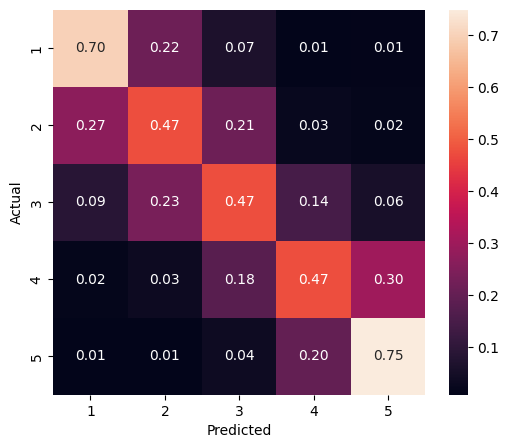

In [333]:
cm = confusion_matrix(y_, y_pred_class)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [340]:
fig.savefig('./plots/confusion_matrix.png')

In [379]:
test_grouped = test.groupby(['star_rating']).agg({'review_body':'count'}).reset_index()

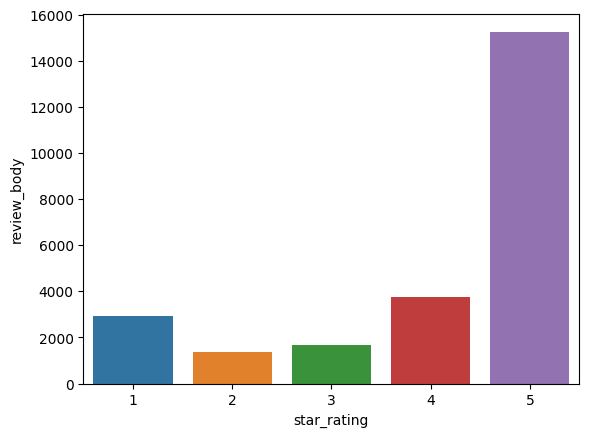

In [ ]:
fig = sns.barplot(data=test_grouped, x='star_rating', y='review_body')
plt.savefig('./plots/barchart.png') 